# Classifying News Headlines into Categories using LSTMs

## Load Libraries

In [1]:
!pip install Keras-Preprocessing

In [12]:
import pandas as pd
import numpy as np
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Load Data

In [6]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/uci-news-aggregator.csv', usecols=['TITLE', 'CATEGORY'])
data.CATEGORY.value_counts()

,count
CATEGORY,
e,152469
b,115967
t,108344
m,45639


## Balance the Data

In [7]:
num_of_categories = 45000
shuffled = data.reindex(np.random.permutation(data.index))
e = shuffled[shuffled['CATEGORY'] == 'e'][:num_of_categories]
b = shuffled[shuffled['CATEGORY'] == 'b'][:num_of_categories]
t = shuffled[shuffled['CATEGORY'] == 't'][:num_of_categories]
m = shuffled[shuffled['CATEGORY'] == 'm'][:num_of_categories]
concated = pd.concat([e,b,t,m], ignore_index=True)

concated = concated.reindex(np.random.permutation(concated.index))
concated['LABEL'] = 0

## Encode the Data

In [8]:
# Whereever the category is e, set the label to 0
concated.loc[concated['CATEGORY'] == 'e', 'LABEL'] = 0
concated.loc[concated['CATEGORY'] == 'b', 'LABEL'] = 1
concated.loc[concated['CATEGORY'] == 't', 'LABEL'] = 2
concated.loc[concated['CATEGORY'] == 'm', 'LABEL'] = 3
print(concated['LABEL'][:10])

# one hot encoding
labels = to_categorical(concated['LABEL'], num_classes=4)

print(labels[:10])

if 'CATEGORY' in concated.keys():
  concated.drop(['CATEGORY'], axis=1)

11388     0
75116     1
178764    3
171869    3
30683     0
55497     1
74796     1
138764    3
70568     1
178434    3
Name: LABEL, dtype: int64
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]]


## Tokenization

In [13]:
n_most_common_words = 8000
max_len = 130
tokenizer = Tokenizer(num_words=n_most_common_words, filters = '!@#$%^&*()_+=-{}[]:;"?><,.~`', lower=True)
tokenizer.fit_on_texts(concated['TITLE'].values)
sequences = tokenizer.texts_to_sequences(concated['TITLE'].values)
word_index = tokenizer.word_index
print(f"Found {len(word_index)} unique tokens")

X = pad_sequences(sequences, maxlen=max_len)

Found 53426 unique tokens


## Craete Train and Test Sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.25, random_state=42)

Setting the Hyperparameters

In [15]:
epochs = 2
emb_dim = 128
batch_size = 256
labels[:2]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

## Define the LSTM Model

In [16]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

model= Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.7))
model.add(LSTM(64, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[EarlyStopping()])

(135000, 130) (45000, 130) (135000, 4) (45000, 4)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 241s 563ms/step - acc: 0.4642 - loss: 1.1808 - val_acc: 0.8723 - val_loss: 0.3580
Epoch 2/2
422/422 ━━━━━━━━━━━━━━━━━━━━ 260s 560ms/step - acc: 0.8393 - loss: 0.4594 - val_acc: 0.9046 - val_loss: 0.2793


## Evaluate Performance and Plot Metrics

In [17]:
accr = model.evaluate(X_test, y_test)
print("Test set")
print("Loss: " + str(accr[0]))
print("Accuracy: " + str(accr[1]))

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step - acc: 0.9034 - loss: 0.2864
Test set
Loss: 0.2806280255317688
Accuracy: 0.9049777984619141


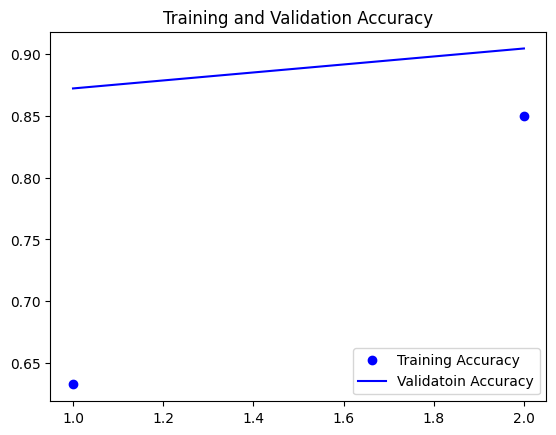

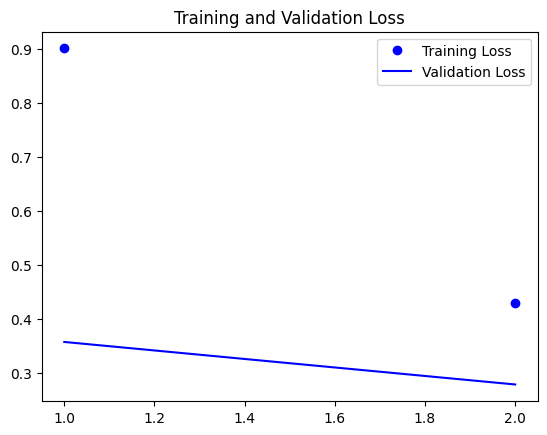

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validatoin Accuracy')
plt.title("Training and Validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

## Perform Predictions

In [39]:
txt = ["ChatGPT maker OpenAI raises $6.6 billion in fresh funding as it moves away from its nonprofit roots"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen= max_len)
pred = model.predict(padded)
labels = ['entertainment', 'bussiness', 'sci/tech', 'health']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.02068776 0.86094373 0.1093341  0.00903445]] bussiness
